In [4]:
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like

In [5]:
import pandas_datareader as pdr
import numpy as np
import scipy.stats as sta
import datetime
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## 1 Problem 1. Binomial/Trinomial Tree Basics

### 1.1 Question 1

In [3]:
def BinomialTree_Eur(so, k, t, r, sigma, N, type):
    """
    s0 is close price of AMZN
    k is strike price
    t is expiration time
    r is interest rate
    N is steps of binomial tree
    """
    dt = t / N
    nu = r - 0.5 * pow(sigma, 2)
    dxu = np.sqrt(pow(sigma, 2) * dt + pow(nu * dt, 2))
    dxd = -dxu
    pu = 1 / 2 + 1 / 2 * (nu * dt / dxu)
    pd = 1 - pu
    
    disc = np.exp(-r * dt)
    St = np.zeros(N + 1)
    C = np.zeros(N + 1)
    
    St[0] = s0 * np.exp(N * dxd)
    for i in range(1, N + 1):
        St[i] = St[i - 1] * np.exp(dxu - dxd)
        
    for i in range(N + 1):
        if type == 'call':
            C[i] = max(0.0, St[i] - k)
        else:
            C[i] = max(0.0, k - St[i])
            
    for j in range(N - 1, -1, -1):
        for i in range(j + 1):
            C[i] = disc * (pu * C[i + 1] + pd * C[i])
    return C[0]

### 1.2 Question 2

In [4]:
# I have downloaded option price of AMZN and saved it as a cvs file.
# I separated Call amd Put opiton data as two csv files and called 'AMZN_Call_Option'
# and 'AMZN_Put_Option'. Also, I have already selected three different maturities at
# Sep.28.2018, Oct.19.2018, and Nov.16.2018
dfc = pd.read_csv('AMZN_Call_Option.csv')
dfp = pd.read_csv('AMZN_Put_Option.csv')

#### Select 20 strike prices for 3 different maturities.

In [5]:
AMZN_M1_C = dfc[100:110]
AMZN_M1_P = dfp[100:110]
AMZN_M2_C = dfc[400:410]
AMZN_M2_P = dfp[400:410]
AMZN_M3_C = dfc[550:560]
AMZN_M3_P = dfp[550:560]

#### Use TM table to save time to maturities

In [6]:
TM1 = (datetime.datetime(2018,9,28) - datetime.datetime(2018,9,24)).days / 365
TM2 = (datetime.datetime(2018,10,19) - datetime.datetime(2018,9,24)).days / 365
TM3 = (datetime.datetime(2018,11,16) - datetime.datetime(2018,9,24)).days / 365
TM = [TM1, TM2, TM3]

#### Black-Scholes Model

In [7]:
def BSM(s0, k, t, r, sigma, type):
    d1 = (np.log(s0 / k) + (r + pow(sigma, 2) / 2) * t) / (sigma * np.sqrt(t))
    d2 = d1 - sigma * np.sqrt(t)
    
    if type == 'call':
        C = s0 * sta.norm.cdf(d1) - k * np.exp(-r * t) * sta.norm.cdf(d2)
        return C
    elif type == 'put':
        P = k * np.exp(-r * t) * sta.norm.cdf(-d2) - s0 * sta.norm.cdf(-d1)
        return P

#### Bisection Method

In [8]:
def Bisection_Method(a, b, f):
    if f(a) * f(b) > 0:
        return "no root found"
    else:
        while ((b - a) / 2.0) > 1e-06:
            midpt = (a + b) / 2.0
            if f(midpt) == 0:
                return midpt
            elif f(a) * f(midpt) < 0:
                b = midpt
            else:
                a = midpt
    return midpt

In [9]:
def f(sigma):
    Option_price = BSM(s0, k, t, r, sigma, type)
    return (Option_price-Market_price)

#### Calculate option price and volatility

In [10]:
def Calculate(Market_Price, strike):
    BS_Implied_Vol = []
    BS_Price = []
    BT_Price = []
    
    global Market_price
    global k
    
    for i in range(20):
        Market_price = Market_Price[i]
        k = strike[i]
        
        sigma = Bisection_Method(-2, 2, f)
        BSPrice = BSM(s0, k, t, r, sigma, type)
        BTPrice = BinomialTree_Eur(s0, k, t, r, sigma, N, type)
        
        BS_Implied_Vol.append(sigma)
        BS_Price.append(BSPrice)
        BT_Price.append(BTPrice)
        
    df_Implied_Vol = pd.DataFrame(BS_Implied_Vol)
    df_BS_Price = pd.DataFrame(BS_Price)
    df_BT_Price = pd.DataFrame(BT_Price)
    
    df_Option_Price = pd.concat([df_BS_Price, df_BT_Price, df_Implied_Vol], axis = 1)
    return df_Option_Price

In [11]:
N = 500
s0 = 1934.36
r = 0.0192

# Call
type = 'call'
# Maturity 1
t = TM[0]
Market_Price = list((AMZN_M1_C['Bid'] + AMZN_M1_C['Ask'])/2)
strike = list(AMZN_M1_C['Strike'])
Option_Price_M1_C = Calculate(Market_Price, strike)

In [12]:
# Maturity 2
t = TM[1]
Market_Price = list((AMZN_M2_C['Bid'] + AMZN_M2_C['Ask'])/2)
strike = list(AMZN_M2_C['Strike'])
Option_Price_M2_C = Calculate(Market_Price, strike)

In [13]:
# Maturity 3
t = TM[2]
Market_Price = list((AMZN_M3_C['Bid'] + AMZN_M3_C['Ask'])/2)
strike = list(AMZN_M3_C['Strike'])
Option_Price_M3_C = Calculate(Market_Price, strike)

In [14]:
# Put
type = 'put'
# Maturity 1
t = TM[0]
Market_Price = list((AMZN_M1_P['Bid'] + AMZN_M1_P['Ask'])/2)
strike = list(AMZN_M1_P['Strike'])
Option_Price_M1_P = Calculate(Market_Price, strike)

In [15]:
# Maturity 2
t = TM[1]
Market_Price = list((AMZN_M2_P['Bid'] + AMZN_M2_P['Ask'])/2)
strike = list(AMZN_M2_P['Strike'])
Option_Price_M2_P = Calculate(Market_Price, strike)

In [16]:
# Maturity 3
t = TM[2]
Market_Price = list((AMZN_M3_P['Bid'] + AMZN_M3_P['Ask'])/2)
strike = list(AMZN_M3_P['Strike'])
Option_Price_M3_P = Calculate(Market_Price, strike)

In [17]:
# Combine the data
Option_Price_Eur = pd.concat([Option_Price_M1_C, Option_Price_M2_C, Option_Price_M3_C, 
                              Option_Price_M1_P, Option_Price_M2_P, Option_Price_M3_P], axis = 1)

Option_Price_Eur.columns = ['M1_C_BS', 'M1_C_BT', 'M1_C_Implied_Vol', 
                           'M2_C_BS', 'M2_C_BT', 'M2_C_Implied_Vol', 
                           'M3_C_BS', 'M3_C_BT', 'M3_C_Implied_Vol', 
                           'M1_P_BS', 'M1_P_BT', 'M1_P_Implied_Vol', 
                           'M2_P_BS', 'M2_P_BT', 'M2_P_Implied_Vol', 
                           'M3_P_BS', 'M3_P_BT', 'M3_P_Implied_Vol']
Option_Price_Eur

,M1_C_BS,M1_C_BT,M1_C_Implied_Vol,M2_C_BS,M2_C_BT,M2_C_Implied_Vol,M3_C_BS,M3_C_BT,M3_C_Implied_Vol,M1_P_BS,M1_P_BT,M1_P_Implied_Vol,M2_P_BS,M2_P_BT,M2_P_Implied_Vol,M3_P_BS,M3_P_BT,M3_P_Implied_Vol
0,40.224967,40.225090,0.118696,39.399915,39.389831,0.236078,88.575415,88.593156,0.285215,3.649989,3.639583,0.452917,137.775238,137.786021,0.320684,191.925137,191.876164,0.354502
1,38.599979,38.600055,0.143957,37.449783,37.469962,0.236814,87.300245,87.288274,0.285070,3.775017,3.772794,0.449453,141.999734,141.968857,0.323080,195.850391,195.854608,0.355707
2,36.699925,36.701662,0.152140,35.974982,35.980861,0.239557,86.275055,86.244175,0.285738,3.850062,3.852106,0.444326,153.074949,153.093777,0.366816,199.324720,199.361372,0.355097
3,35.074951,35.073528,0.163248,34.074764,34.085876,0.239779,84.700086,84.704857,0.284491,4.199983,4.198739,0.447161,150.399757,150.420107,0.326994,215.624539,215.594378,0.360914
4,32.974984,32.971096,0.162561,32.024719,32.038190,0.238836,82.400398,82.428956,0.280737,4.124949,4.123105,0.437437,161.374775,161.378024,0.370966,195.675220,195.677782,0.183649
5,31.700074,31.704304,0.175299,30.000113,30.004310,0.237608,82.024537,82.064715,0.283495,4.324954,4.316980,0.435499,165.724947,165.692976,0.374010,241.674670,241.658798,0.340094
6,30.100032,30.104934,0.180311,28.025232,28.040875,0.236212,80.950383,80.990543,0.283834,4.675061,4.679212,0.437342,165.225171,165.200988,0.346087,0.000000,229.598584,-0.000002
7,27.824946,27.819284,0.173811,26.024851,26.025955,0.234236,79.874622,79.903082,0.284128,4.774937,4.777993,0.432196,174.874950,174.895533,0.382494,273.649934,273.674346,0.374800
8,26.650117,26.648945,0.182955,24.924723,24.943639,0.236723,78.625552,78.630276,0.283792,4.774990,4.775712,0.424379,179.399718,179.423407,0.386255,304.400172,304.384525,0.362993
9,23.899934,23.905338,0.168550,23.574967,23.551784,0.237513,77.474572,77.443935,0.283751,4.900040,4.892271,0.419722,0.000000,157.886742,-0.000002,319.600261,319.628618,0.396734


From the output table we can see that option price calculated by binimial tree and Black-Scholes formula are very close.

### 1.3 Question 3

#### Compute the absoluate errors

In [18]:
def AbsoluateError(Market_Price, strike):
    Option_Price = Calculate(Market_Price, strike)
    Option_Price.columns = ['BS', 'BT', 'Implied Vol']
    AbsError = abs(Option_Price['BS'] - Option_Price['BT'])
    AvgError = np.mean(AbsError)
    return AvgError

In [19]:
N_list = [50, 100, 150, 200, 250, 300, 350, 400]

# Call
type = 'call'

AbsError_M1 = []
AbsError_M2 = []
AbsError_M3 = []

# Maturity 1
t = TM[0]
Market_Price = list((AMZN_M1_C['Bid'] + AMZN_M1_C['Ask']) / 2)
strike = list(AMZN_M1_C['Strike'])

for i in range(len(N_list)):
    N = N_list[i]
    AbsError_M1.append(AbsoluateError(Market_Price, strike))

In [20]:
# Maturity 2
t = TM[1]
Market_Price = list((AMZN_M2_C['Bid'] + AMZN_M2_C['Ask']) / 2)
strike = list(AMZN_M2_C['Strike'])

for i in range(len(N_list)):
    N = N_list[i]
    AbsError_M2.append(AbsoluateError(Market_Price, strike))

In [21]:
# Maturity 3
t = TM[2]
Market_Price = list((AMZN_M3_C['Bid'] + AMZN_M3_C['Ask']) / 2)
strike = list(AMZN_M3_C['Strike'])

for i in range(len(N_list)):
    N = N_list[i]
    AbsError_M3.append(AbsoluateError(Market_Price, strike))

In [22]:
df_Steps = pd.DataFrame(N_list, columns = ['N'])
df_AnsError_M1 = pd.DataFrame(AbsError_M1, columns = ['M1_C'])
df_AnsError_M2 = pd.DataFrame(AbsError_M2, columns = ['M2_C'])
df_AnsError_M3 = pd.DataFrame(AbsError_M3, columns = ['M3_C'])

AbsError = pd.concat([df_Steps, df_AnsError_M1, df_AnsError_M2, df_AnsError_M3], axis = 1)

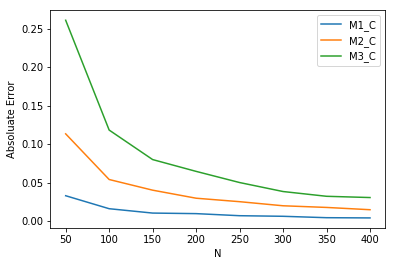

In [23]:
# Plot
data = AbsError
plt.plot(data['N'], data['M1_C'])
plt.plot(data['N'], data['M2_C'])
plt.plot(data['N'], data['M3_C'])
plt.xlabel('N')
plt.ylabel('Absoluate Error')
plt.legend()
plt.show()

From the plot we can see that as steps of binomial tree increases,  the absoluate error of call options with different maturities decreases. Because as the steps becomes more and more, tree model will becomes preciser approximation of BS model. Threrefore, the difference between them will become smaller amd smaller.

### 1.4 Question 4

In [24]:
def BinomialTree_Amer(s0, k, t, r, sigma, N, type):
    """
    s0 is close price of AMZN
    k is strike price
    t is expiration time
    r is interest rate
    N is steps of binomial tree
    """
    dt = t / N
    nu = r - 0.5 * pow(sigma, 2)
    dxu = np.sqrt(pow(sigma, 2) * dt + pow(nu * dt, 2))
    dxd = -dxu
    pu = 1 / 2 + 1 / 2 * (nu * dt / dxu)
    pd = 1 - pu
    
    disc = np.exp(-r * dt)
    dpu = disc * pu
    dpd = disc * pd
    St = np.zeros(N + 1)
    C = np.zeros(N + 1)
    
    St[0] = s0 * np.exp(N * dxd)
    for i in range(1, N + 1):
        St[i] = St[i - 1] * np.exp(dxu - dxd)
        
    for i in range(N + 1):
        if type == 'call':
            C[i] = max(0.0, St[i] - k)
        else:
            C[i] = max(0.0, k - St[i])
            
    for j in range(N - 1, -1, -1):
        for i in range(j + 1):
            C[i] = disc * (pu * C[i + 1] + pd * C[i])
            
            St[i] = St[i] / np.exp(dxd)
            if type == 'call':
                C[i] = max(C[i], St[i] - k)
            else:
                C[i] = max(C[i], k - St[i])
    return C[0]

def Calculate_Amer(Market_Price, strike):
    BT_Price = []
    global Market_price
    global k
    
    for i in range(20):
        Market_price = Market_Price[i]
        k = strike[i]
        
        sigma = Bisection_Method(-2, 2, f)
        BTPrice = BinomialTree_Amer(s0, k, t, r, sigma, N, type)
        BT_Price.append(BTPrice)
        
    df_Option_Price = pd.DataFrame(BT_Price)
    return df_Option_Price

In [25]:
N = 500

# Call
type = 'call'

# Maturity 1
t = TM[0]
Market_Price = list((AMZN_M1_C['Bid'] + AMZN_M1_C['Ask'])/2)
strike = list(AMZN_M1_C['Strike'])
Option_Price_M1_C = Calculate_Amer(Market_Price, strike)

In [26]:
# Maturity 2
t = TM[1]
Market_Price = list((AMZN_M2_C['Bid'] + AMZN_M2_C['Ask'])/2)
strike = list(AMZN_M2_C['Strike'])
Option_Price_M2_C = Calculate_Amer(Market_Price, strike)

In [27]:
# Maturity 3
t = TM[2]
Market_Price = list((AMZN_M3_C['Bid'] + AMZN_M3_C['Ask'])/2)
strike = list(AMZN_M3_C['Strike'])
Option_Price_M3_C = Calculate_Amer(Market_Price, strike)

In [28]:
# Put
type = 'put'
# Maturity 1
t = TM[0]
Market_Price = list((AMZN_M1_P['Bid'] + AMZN_M1_P['Ask'])/2)
strike = list(AMZN_M1_P['Strike'])
Option_Price_M1_P = Calculate_Amer(Market_Price, strike)

In [29]:
# Maturity 2
t = TM[1]
Market_Price = list((AMZN_M2_P['Bid'] + AMZN_M2_P['Ask'])/2)
strike = list(AMZN_M2_P['Strike'])
Option_Price_M2_P = Calculate_Amer(Market_Price, strike)

In [30]:
# Maturity 3
t = TM[2]
Market_Price = list((AMZN_M3_P['Bid'] + AMZN_M3_P['Ask'])/2)
strike = list(AMZN_M3_P['Strike'])
Option_Price_M3_P = Calculate_Amer(Market_Price, strike)

In [31]:
Option_Price_Amer = pd.concat([Option_Price_M1_C, Option_Price_M2_C, Option_Price_M3_C, 
                              Option_Price_M1_P, Option_Price_M2_P, Option_Price_M3_P], axis = 1)

Option_Price_Amer.columns = ['M1_C_BT', 'M2_C_BT', 'M3_C_BT',
                            'M1_P_BT', 'M2_P_BT', 'M3_P_BT']

Option_Price_Amer

,M1_C_BT,M2_C_BT,M3_C_BT,M1_P_BT,M2_P_BT,M3_P_BT
0,40.225090,39.389831,88.593156,3.640708,138.191160,192.658274
1,38.600055,37.469962,87.288274,3.774004,142.390515,196.651798
2,36.701662,35.980861,86.244175,3.853340,153.474567,200.178305
3,35.073528,34.085876,84.704857,4.200052,150.866140,216.491483
4,32.971096,32.038190,82.428956,4.124428,161.781631,198.187077
5,31.704304,30.004310,82.064715,4.318468,166.110000,242.824600
6,30.104934,28.040875,80.990543,4.680764,165.670482,235.640000
7,27.819284,26.025955,79.903082,4.779588,175.327561,274.866732
8,26.648945,24.943639,78.630276,4.777339,179.864357,305.866528
9,23.905338,23.551784,77.443935,4.893981,160.640000,320.999702


### 1.5 Question 5

In [32]:
Bid_M1_C = AMZN_M1_C['Bid'].reset_index(drop = True)
Ask_M1_C = AMZN_M1_C['Ask'].reset_index(drop = True)
Bid_M2_C = AMZN_M2_C['Bid'].reset_index(drop = True)
Ask_M2_C = AMZN_M2_C['Ask'].reset_index(drop = True)
Bid_M3_C = AMZN_M3_C['Bid'].reset_index(drop = True)
Ask_M3_C = AMZN_M3_C['Ask'].reset_index(drop = True)
Bid_M1_P = AMZN_M1_P['Bid'].reset_index(drop = True)
Ask_M1_P = AMZN_M1_P['Ask'].reset_index(drop = True)
Bid_M2_P = AMZN_M2_P['Bid'].reset_index(drop = True)
Ask_M2_P = AMZN_M2_P['Ask'].reset_index(drop = True)
Bid_M3_P = AMZN_M3_P['Bid'].reset_index(drop = True)
Ask_M3_P = AMZN_M3_P['Ask'].reset_index(drop = True)

In [33]:
Option_Price = pd.concat([Bid_M1_C, Ask_M1_C, Option_Price_Eur[['M1_C_BS', 'M1_C_BT']], Option_Price_Amer['M1_C_BT'], Bid_M2_C,
                         Ask_M2_C, Option_Price_Eur[['M2_C_BS', 'M2_C_BT']], Option_Price_Amer['M2_C_BT'], Bid_M3_C, Ask_M3_C,
                         Option_Price_Eur[['M3_C_BS', 'M3_C_BT']], Option_Price_Amer['M3_C_BT'], Bid_M1_P, Ask_M1_P,
                         Option_Price_Eur[['M1_P_BS', 'M1_P_BT']], Option_Price_Amer['M1_P_BT'], Bid_M2_P, Ask_M2_P,
                         Option_Price_Eur[['M2_P_BS', 'M2_P_BT']], Option_Price_Amer['M2_P_BT'], Bid_M3_P, Ask_M3_P,
                         Option_Price_Eur[['M3_P_BS', 'M3_P_BT']], Option_Price_Amer['M3_P_BT']], axis = 1)

Option_Price.columns = ['M1_C_Bid', 'M1_C_Ask', 'M1_C_BS', 'M1_C_BT_Eur', 'M1_C_BT_Amer',
                        'M2_C_Bid', 'M2_C_Ask', 'M2_C_BS', 'M2_C_BT_Eur', 'M2_C_BT_Amer',
                        'M3_C_Bid', 'M3_C_Ask', 'M3_C_BS', 'M3_C_BT_Eur', 'M3_C_BT_Amer',
                        'M1_P_Bid', 'M1_P_Ask', 'M1_P_BS', 'M1_P_BT_Eur', 'M1_P_BT_Amer',
                        'M2_P_Bid', 'M2_P_Ask', 'M2_P_BS', 'M2_P_BT_Eur', 'M2_P_BT_Amer',
                        'M3_P_Bid', 'M3_P_Ask', 'M3_P_BS', 'M3_P_BT_Eur', 'M3_P_BT_Amer',]

Option_Price

,M1_C_Bid,M1_C_Ask,M1_C_BS,M1_C_BT_Eur,M1_C_BT_Amer,M2_C_Bid,M2_C_Ask,M2_C_BS,M2_C_BT_Eur,M2_C_BT_Amer,...,M2_P_Bid,M2_P_Ask,M2_P_BS,M2_P_BT_Eur,M2_P_BT_Amer,M3_P_Bid,M3_P_Ask,M3_P_BS,M3_P_BT_Eur,M3_P_BT_Amer
0,39.60,40.85,40.224967,40.225090,40.225090,38.70,40.10,39.399915,39.389831,39.389831,...,136.55,139.00,137.775238,137.786021,138.191160,187.35,196.50,191.925137,191.876164,192.658274
1,38.10,39.10,38.599979,38.600055,38.600055,36.85,38.05,37.449783,37.469962,37.469962,...,140.80,143.20,141.999734,141.968857,142.390515,191.40,200.30,195.850391,195.854608,196.651798
2,36.10,37.30,36.699925,36.701662,36.701662,35.55,36.40,35.974982,35.980861,35.980861,...,148.55,157.60,153.074949,153.093777,153.474567,194.70,203.95,199.324720,199.361372,200.178305
3,34.75,35.40,35.074951,35.073528,35.073528,33.55,34.60,34.074764,34.085876,34.085876,...,148.85,151.95,150.399757,150.420107,150.866140,213.25,218.00,215.624539,215.594378,216.491483
4,32.95,33.00,32.974984,32.971096,32.971096,31.60,32.45,32.024719,32.038190,32.038190,...,156.70,166.05,161.374775,161.378024,161.781631,193.80,197.55,195.675220,195.677782,198.187077
5,31.30,32.10,31.700074,31.704304,31.704304,29.65,30.35,30.000113,30.004310,30.004310,...,161.10,170.35,165.724947,165.692976,166.110000,240.75,242.60,241.674670,241.658798,242.824600
6,29.60,30.60,30.100032,30.104934,30.104934,27.65,28.40,28.025232,28.040875,28.040875,...,163.10,167.35,165.225171,165.200988,165.670482,224.20,228.30,0.000000,229.598584,235.640000
7,27.35,28.30,27.824946,27.819284,27.819284,25.60,26.45,26.024851,26.025955,26.025955,...,170.15,179.60,174.874950,174.895533,175.327561,269.55,277.75,273.649934,273.674346,274.866732
8,26.15,27.15,26.650117,26.648945,26.648945,24.55,25.30,24.924723,24.943639,24.943639,...,174.70,184.10,179.399718,179.423407,179.864357,302.90,305.90,304.400172,304.384525,305.866528
9,23.25,24.55,23.899934,23.905338,23.905338,23.30,23.85,23.574967,23.551784,23.551784,...,140.50,145.50,0.000000,157.886742,160.640000,315.20,324.00,319.600261,319.628618,320.999702


From table we can see that the option price is very close to the average of actual bid and ask values. Besides, the price of American call options is almost the same as European call options because of no dividends. And the price of American put options are expensive than European put options due to the early exercise rights.

### 1.6 Question 6

In [34]:
# Using binomial tree to calculate implied volatility
def g(sigma):
    Option_price = BinomialTree_Amer(s0, k, t, r, sigma, N, type)
    return (Option_price - Market_price)

In [35]:
def Calculate_Implied_Vol(Market_Price, strike):
    BT_Implied_Vol = []
    
    global Market_price
    global k
    
    for i in range(20):
        Market_price = Market_Price[i]
        k = strike[i]
        
        sigma = Bisection_Method(0, 1, g)
        BT_Implied_Vol.append(sigma)
    
    df_Implied_Vol = pd.DataFrame(BT_Implied_Vol)
    return df_Implied_Vol

In [36]:
# Call
type = 'call'

# Maturity 1
t = TM[0]
Market_Price = list((AMZN_M1_C['Bid'] + AMZN_M1_C['Ask']) / 2)
strike = list(AMZN_M1_C['Strike'])
Implied_Vol_M1_C = Calculate_Implied_Vol(Market_Price, strike)

In [37]:
# Maturity 2
t = TM[1]
Market_Price = list((AMZN_M2_C['Bid'] + AMZN_M2_C['Ask']) / 2)
strike = list(AMZN_M2_C['Strike'])
Implied_Vol_M2_C = Calculate_Implied_Vol(Market_Price, strike)

In [38]:
# Maturity 3
t = TM[2]
Market_Price = list((AMZN_M3_C['Bid'] + AMZN_M3_C['Ask']) / 2)
strike = list(AMZN_M3_C['Strike'])
Implied_Vol_M3_C = Calculate_Implied_Vol(Market_Price, strike)

In [39]:
# Put
type = 'put'

# Maturity 1
t = TM[0]
Market_Price = list((AMZN_M1_P['Bid'] + AMZN_M1_P['Ask']) / 2)
strike = list(AMZN_M1_P['Strike'])
Implied_Vol_M1_P = Calculate_Implied_Vol(Market_Price, strike)

In [40]:
# Maturity 2
t = TM[1]
Market_Price = list((AMZN_M2_P['Bid'] + AMZN_M2_P['Ask']) / 2)
strike = list(AMZN_M2_P['Strike'])
Implied_Vol_M2_P = Calculate_Implied_Vol(Market_Price, strike)

In [41]:
# Maturity 3
t = TM[2]
Market_Price = list((AMZN_M3_P['Bid'] + AMZN_M3_P['Ask']) / 2)
strike = list(AMZN_M3_P['Strike'])
Implied_Vol_M3_P = Calculate_Implied_Vol(Market_Price, strike)

In [42]:
Implied_Vol = pd.concat([Option_Price_Eur['M1_C_Implied_Vol'], Implied_Vol_M1_C, Option_Price_Eur['M2_C_Implied_Vol'],
                         Implied_Vol_M2_C, Option_Price_Eur['M3_C_Implied_Vol'], Implied_Vol_M3_C,
                         Option_Price_Eur['M1_P_Implied_Vol'], Implied_Vol_M1_P, Option_Price_Eur['M2_P_Implied_Vol'],
                         Implied_Vol_M2_P, Option_Price_Eur['M3_P_Implied_Vol'], Implied_Vol_M3_P], axis = 1)

Implied_Vol.columns = ['M1_C_Implied_Vol_BS', 'M1_C_Implied_Vol_BT', 'M2_C_Implied_Vol_BS', 'M2_C_Implied_Vol_BT',
                       'M3_C_Implied_Vol_BS', 'M3_C_Implied_Vol_BT', 'M1_P_Implied_Vol_BS', 'M1_P_Implied_Vol_BT',
                       'M2_P_Implied_Vol_BS', 'M2_P_Implied_Vol_BT', 'M3_P_Implied_Vol_BS', 'M3_P_Implied_Vol_BT']

Implied_Vol

,M1_C_Implied_Vol_BS,M1_C_Implied_Vol_BT,M2_C_Implied_Vol_BS,M2_C_Implied_Vol_BT,M3_C_Implied_Vol_BS,M3_C_Implied_Vol_BT,M1_P_Implied_Vol_BS,M1_P_Implied_Vol_BT,M2_P_Implied_Vol_BS,M2_P_Implied_Vol_BT,M3_P_Implied_Vol_BS,M3_P_Implied_Vol_BT
0,0.118696,0.118692,0.236078,0.236128,0.285215,0.285154,0.452917,0.453230,0.320684,0.318178,0.354502,0.35166
1,0.143957,0.143957,0.236814,0.236715,0.285070,0.285109,0.449453,0.449484,0.323080,0.320581,0.355707,0.352602
2,0.152140,0.152102,0.239557,0.239527,0.285738,0.285845,0.444326,0.444227,0.366816,0.36442,0.355097,0.351793
3,0.163248,0.163279,0.239779,0.239721,0.284491,0.284475,0.447161,0.447161,0.326994,0.324015,0.360914,0.357386
4,0.162561,0.162638,0.238836,0.238768,0.280737,0.280638,0.437437,0.437452,0.370966,0.368528,0.183649,0.143454
5,0.175299,0.175226,0.237608,0.237585,0.283495,0.283361,0.435499,0.435671,0.374010,0.371557,0.340094,0.334764
6,0.180311,0.180235,0.236212,0.236128,0.283834,0.283697,0.437342,0.437189,0.346087,0.343142,-0.000002,no root found
7,0.173811,0.173895,0.234236,0.234232,0.284128,0.284033,0.432196,0.432074,0.382494,0.379614,0.374800,0.369188
8,0.182955,0.182970,0.236723,0.236620,0.283792,0.283773,0.424379,0.424318,0.386255,0.383303,0.362993,0.355009
9,0.168550,0.168474,0.237513,0.237642,0.283751,0.283857,0.419722,0.419882,-0.000002,no root found,0.396734,0.389784


The implied volatilities calculated from binomial tree and Black-Scholes formula using bisection method are almost same.

### 1.7 Question 7

In [43]:
def TrinomialTree_Amer(s0, k, t, r, sigma, div, N, type):
    dt = t / N
    nu = r - div - 0.5 * pow(sigma, 2)
    dx = sigma * np.sqrt(3 * dt)
    edx = np.exp(dx)
    pu = 0.5 * ((pow(sigma, 2) * dt + pow(nu * dt, 2)) / pow(dx, 2) + nu * dt / dx)
    pm = 1 - (pow(sigma, 2) * dt + pow(nu * dt, 2)) / pow(dx, 2)
    pd = 0.5 * ((pow(sigma, 2) * dt + pow(nu * dt, 2)) / pow(dx, 2) - nu * dt / dx)
    
    disc = np.exp(-r * dt)
    
    St = np.zeros(2 * N + 1)
    C = np.zeros([N + 1, 2 * N + 1])
    St[-N] = s0 * np.exp(-N * dx)
    
    for i in range(-N + 1, N + 1):
        St[i] = St[i - 1] * edx
    for i in range(-N, N + 1):
        if type =='call':
            C[N, i] = max(0.0, St[i] - k)
        else:
            C[N, i] = max(0.0, k - St[i])
            
    for j in range(N - 1, -1, -1):
        for i in range(-i, i + 1):
            C[j, i] = disc * (pu * C[j + 1, i + 1] + pm * C[j + 1, i] + pd * C[j + 1, i - 1])
            if type == 'call':
                C[j, i] = max(C[j, i], St[i] - k)
            else:
                C[j, i] = max(C[j, i], k - St[i])
                
    return C[0, 0]

In [1]:
def Calculate_TT(Market_Price, strike):
    TT_Price = []
    global Market_price
    global k
    
    for i in range(20):
        Market_price = Market_Price[i]
        k = strike[i]
        
        sigma = Bisection_Method(-2, 2, f)
        TT_price = TrinomialTree_Amer(s0, k, t, r, sigma, div, N, type)
        TT_Price.append(TT_price)
    
    df_Option_Price = pd.DataFrame(TT_Price)
    
    return df_Option_Price

In [45]:
# Calculate price
type = 'put'
div = 0

In [46]:
# Maturity 1
t = TM[0]
Market_Price = list((AMZN_M1_P['Bid'] + AMZN_M1_P['Ask']) / 2)
strike = list(AMZN_M1_P['Strike'])
TT_M1_P = Calculate_TT(Market_Price, strike)

In [47]:
# Maturity 2
t = TM[1]
Market_Price = list((AMZN_M2_P['Bid'] + AMZN_M2_P['Ask']) / 2)
strike = list(AMZN_M2_P['Strike'])
TT_M2_P = Calculate_TT(Market_Price, strike)

In [48]:
# Maturity 3
t = TM[2]
Market_Price = list((AMZN_M3_P['Bid'] + AMZN_M3_P['Ask']) / 2)
strike = list(AMZN_M3_P['Strike'])
TT_M3_P = Calculate_TT(Market_Price, strike)

In [49]:
Option_Price_Amer_Tree = pd.concat([Option_Price_Amer['M1_P_BT'], TT_M1_P, Option_Price_Amer['M2_P_BT'], TT_M2_P, 
                                    Option_Price_Amer['M3_P_BT'], TT_M3_P], axis = 1)

Option_Price_Amer_Tree.columns = ['M1_P_BT', 'M1_P_TT', 'M2_P_BT', 'M2_P_TT', 'M3_P_BT', 'M3_P_TT']

Option_Price_Amer_Tree

,M1_P_BT,M1_P_TT,M2_P_BT,M2_P_TT,M3_P_BT,M3_P_TT
0,3.640708,3.653397,138.191160,138.161248,192.658274,192.665077
1,3.774004,3.772567,142.390515,142.416423,196.651798,196.626111
2,3.853340,3.847434,153.474567,153.465863,200.178305,200.152582
3,4.200052,4.204778,150.866140,150.835651,216.491483,216.500514
4,4.124428,4.129508,161.781631,161.747294,198.187077,198.179499
5,4.318468,4.322264,166.110000,166.138856,242.824600,242.845551
6,4.680764,4.679739,165.670482,165.697386,235.640000,235.640000
7,4.779588,4.780286,175.327561,175.312079,274.866732,274.831440
8,4.777339,4.778947,179.864357,179.825897,305.866528,305.861441
9,4.893981,4.897452,160.640000,160.640000,320.999702,320.954394


Compared the results obtained form binomial tree and trinomial tree models, the American option prices are very close no matter using any one of them.

## Problem 2. Adapting Binomial tree to time varying coefficients

### 2.1 Question 1

In [26]:
def appx_Binomial(s0, k, t, type):
    import random
    N = 12
    v = np.zeros(N + 1)
    r = np.zeros(N + 1)
    sig = np.zeros(N + 1)
    p = np.zeros(N + 1)
    u = np.zeros(N + 1)
    d = np.zeros(N + 1)
    dt = np.zeros(N + 1)
    dx = np.zeros(N + 1)
    
    for t in range(N + 1):
        r[t] = 0.05 * (1 + 0.01 * t)
        sig[t] = 0.3 * (1 + 0.005 * t)
        v[t] = r[t] - 0.5 * pow(sig[t], 2)
    for i in range(N + 1):
        u[i] = np.exp(sig[i] * np.sqrt(dt[i]))
        d[i] = 1 / u[i]
        dx[i] = random.uniform(0.02, 0.08)

    for i in range(N + 1):
        p[i] = 0.5 + v[i]*dt[i] / 2 * dx[i]
        if type == 'call':
            dt[i] = (pow(-sig[i],2) + np.sqrt(pow(sig[i], 4) + 4 * v[i] * pow(dx[i], 2))) / 2 * pow(v[i], 2)
        else:
            dt[i] = (pow(-sig[i], 2) - np.sqrt(pow(sig[i], 4) + 4 * v[i] * pow(dx[i], 2))) / 2 * pow(v[i], 2)
        
    St = np.zeros([N + 1, N + 1])
    C = np.zeros([N + 1, N + 1])
    St[0, 0] = np.log(s0)
    for i in range(N + 1):
        for j in range(i + 1):
            St[j, i] = s0 * (d[i]**j) * (u[i]**(i - j))
            
    for j in range(N + 1):
        if type == 'call':
            C[N, j] = max(0, St[N, j] - k)
        else:
            C[N, j] = max(0, k - St[N, j])
    
    for i in range(N - 1, -1, -1):
        for j in range(0, i + 1):
            C[j, i] = np.exp(-r[i] * dt[i]) * (p[i] * C[j, i + 1] + (1 - p[i]) * C[j + 1, i + 1])
            
    return C[0, 0]

In [73]:
def Varying_Coef(n):
    r = np.zeros(n + 1)
    v = np.zeros(n + 1)
    sig = np.zeros(n + 1)
    dti = np.zeros(n + 1)
    p = np.zeros(n + 1)
    
    for t in range(n + 1):
        r[t] = 0.05 * (1 + 0.01 * t)
        sig[t] = 0.3 * (1 + 0.005 * t)
        v[t] = r[t] - 0.5 * pow(sig[t], 2)
    
    sig_square = np.mean(pow(sig, 2))
    v_square = np.mean(pow(v, 2))
    
    t_ = 1 / n
    dx = np.sqrt(sig_square * t_ + v_square * pow(t_, 2))
    
    for i in range(n + 1):
        cons = pow(sig[i], 4) + 4 * pow(v[i] * dx, 2)
        dti[i] = (-pow(sig[i], 2) + np.sqrt(cons)) / (2 * pow(v[i], 2))
        p[i] = 0.5 + v[i] * dti[i] / (2 * dx)
        
    df_r = pd.DataFrame(r)
    df_v = pd.DataFrame(v)
    df_sig = pd.DataFrame(sig)
    df_dti = pd.DataFrame(dti)
    df_p = pd.DataFrame(p)
    
    df = pd.concat([df_r, df_v, df_sig, df_dti, df_p], axis = 1)
    df.columns = ['r', 'v', 'sigma', 'dt', 'p']
    df.index.name = 'i'
    return df

Varying_Coef(12)[1:12]

,r,v,sigma,dt,p
i,,,,,
1,0.0505,0.005049,0.3015,0.087560,0.502478
2,0.0510,0.005096,0.3030,0.086695,0.502476
3,0.0515,0.005140,0.3045,0.085843,0.502473
4,0.0520,0.005182,0.3060,0.085003,0.502469
5,0.0525,0.005222,0.3075,0.084176,0.502463
6,0.0530,0.005260,0.3090,0.083361,0.502457
7,0.0535,0.005295,0.3105,0.082557,0.502450
8,0.0540,0.005328,0.3120,0.081765,0.502442
9,0.0545,0.005359,0.3135,0.080985,0.502432


### 2.2 Question 2

In [86]:
# I have used Secant Method to determine the optimal value of dx
def Calculate_dti(dx):
    n = 11
    v = np.zeros(n + 1)
    r = np.zeros(n + 1)
    sig = np.zeros(n + 1)
    dti = np.zeros(n + 1)
    
    for t in range(n + 1):
        r[t] = 0.05 * (1 + 0.01 * t)
        sig[t] = 0.3 * (1 + 0.005 * t)
        v[t] = r[t] - 0.5 * pow(sig[t], 2)
        
    for i in range(n + 1):
        cons = pow(sig[i], 4) + 4 * pow(v[i] * dx, 2)
        dti[i] = (-pow(sig[i], 2) + np.sqrt(cons)) / (2 * pow(v[i], 2))
    
    return dti

In [2]:
def Secant(a, b, f, tol = 1e-6, n = 500):
    x0 = a
    x1 = b
    for i in range(1, n):
        x2 = x1 - f(x1) / ((f(x1) - f(x0)) / (x1 - x0))
        if abs(x2 - x1) < tol:
            return x2
        x0 = x1
        x1 = x2

In [88]:
def H(dx):
    result = sum(Calculate_dti(dx)) - 1
    return result

In [89]:
Secant(0.02, 0.08, H)

0.08894750352844627

### 2.3 Question 3

In [27]:
dx = 0.02
s0 = np.log(10)
k = 10
t = 0.5
# Call
type = 'call'
appx_Binomial(s0, k, t, type)

0.0

In [28]:
# Put
type = 'put'

appx_Binomial(s0, k, t, type)

0.0018792516914974786

## Problem 3. Dealing with discrete cash dividends

In [92]:
def Tree(s0, k, t, r, sigma, tau, D, N, type):
    dt = t / N
    disc = np.exp(-r * dt)
    v = r - 0.5 * pow(sigma, 2)
    dxu = np.sqrt(pow(sigma, 2) * dt + pow(v * dt, 2))
    dxd = -dxu
    pu = 0.5 + 0.5 * (v * dt) / dxu
    pd = 1 - pu
    dpu = disc * pu
    dpd = disc * pd
    edxud = np.exp(dxu - dxd)
    edxd = np.exp(dxd)
    
    St = np.zeros((N + 1, N + 1))
    C = np.zeros((N + 1, N + 1))
    St[0, 0] = s0
    
    for i in range(1, N + 1):
        St[i, 0] = (s0 - D * np.exp(-r * tau)) * np.exp(N * dxd)
        for j in range(1, N + 1):
            St[i, j] = St[i, j - 1] * edxud
            
    for j in range(N + 1):
        if type == 'call':
            C[N, j] = max(0, St[N, j] - k)
        else:
            C[N, j] = max(0, k - St[N, j])
            
    for i in range(N - 1, -1, -1):
        for j in range(i + 1):
            C[i, j] = C[i + 1, j] * dpu + C[i + 1, j - 1] * dpd
            
    return C[0, 0]

In [131]:
# Call
type = 'call'
r = 0.001
sigma = 0.4
s0 = 100
k = 90
t = 2 / 12
D = 0.6
tau = 1 / 24
N = 30

Tree(s0, k, t, r, sigma, tau, D, N, type)

9.413040861285256e-08

In [132]:
# Put
type = 'put'

Tree(s0, k, t, r, sigma, tau, D, N, type)

2.9461048786033288e-08